# avidaR: examples of use
> as shown in the paper submitted to *PeerJ Computational Biology*

---
---

## install latest version of avidaR:

### from the master branch:

In [ ]:
devtools::install_gitlab("fortunalab/avidaR@main")

### from the development branch:

In [ ]:
devtools::install_gitlab("fortunalab/avidaR@development")

## load required libraries:

In [1]:
library("tidyverse")
library("avidaR")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## set access to avidaDB:

In [2]:
avidaDB <- triplestore_access$new()
avidaDB$set_access_options(
    url = "https://graphdb.fortunalab.org",
    user = "public_avida",
    password = "public_avida",
    repository = "avidaDB"
)

## data reproducibility:

In [3]:
set.seed(1000)

---

## case study: the fitness cost of phenotypic plasticity:

### define function to get the data:

In [4]:
data <- function(boolean_func, seeds, plastic) {
    get_genome_id_from_logic_operation(
        # logic operations that the target organisms must perform:
        logic_operation = boolean_func,
        # number of distinct environments where that phenotype will be computed:
        seed_id = 1:seeds,
        triplestore = avidaDB) %>%
    # show data for each genome that computes those logic operations:
    group_by(genome_id) %>%
    # number of environments where the phenotype was encoded:
    summarize(n_seeds = n()) %>%
    # classify the genome as plastic or no plastic:
    filter(if (plastic == TRUE) n_seeds == seeds else n_seeds == 1) %>%
    # randomly select 10 organisms from those that meet the requirements:
    sample_n(10) %>%
    select(genome_id) %>%
    # get the transcriptome from the genome of each selected organisms:
    get_transcriptome_id_from_genome_id(
        genome_id = as.integer(gsub("genome_", "", .$genome_id)),
        transcriptome_seq = TRUE,
        seed_id = 1:seeds,
        triplestore = avidaDB) %>%
    select(genome_id, transcriptome_id, transcriptome_seq) %>%
    distinct %>%
    # get the number of instructions that the organism executed to replicate as a surrogate for fitness:
    mutate(generation_time = nchar(transcriptome_seq),
        phen_group = boolean_func, plastic_group = plastic) %>%
    select(-transcriptome_seq)
}

### get the data and join them in a single dataframe:

In [5]:
# select 10 non-plastic organisms performing the logic function NOT:
data_NOT_non_plastic <- 
    data(boolean_func = "not", seeds = 10, plastic = FALSE)
# select 10 plastic organisms performing the logic function NOT:
data_NOT_plastic <-
        data(boolean_func = "not", seeds = 10, plastic = TRUE)
# select 10 non-plastic organisms performing the logic function EQUALS:
data_EQU_non_plastic <-
        data(boolean_func = "equals", seeds = 10, plastic = FALSE)
# select 10 plastic organisms performing the logic function EQUALS:
data_EQU_plastic <-
        data(boolean_func = "equals", seeds = 10, plastic = TRUE)
# provide data as a single data frame:
df <- rbind(
    data_NOT_non_plastic, data_NOT_plastic,
    data_EQU_non_plastic, data_EQU_plastic)

### plot the results:

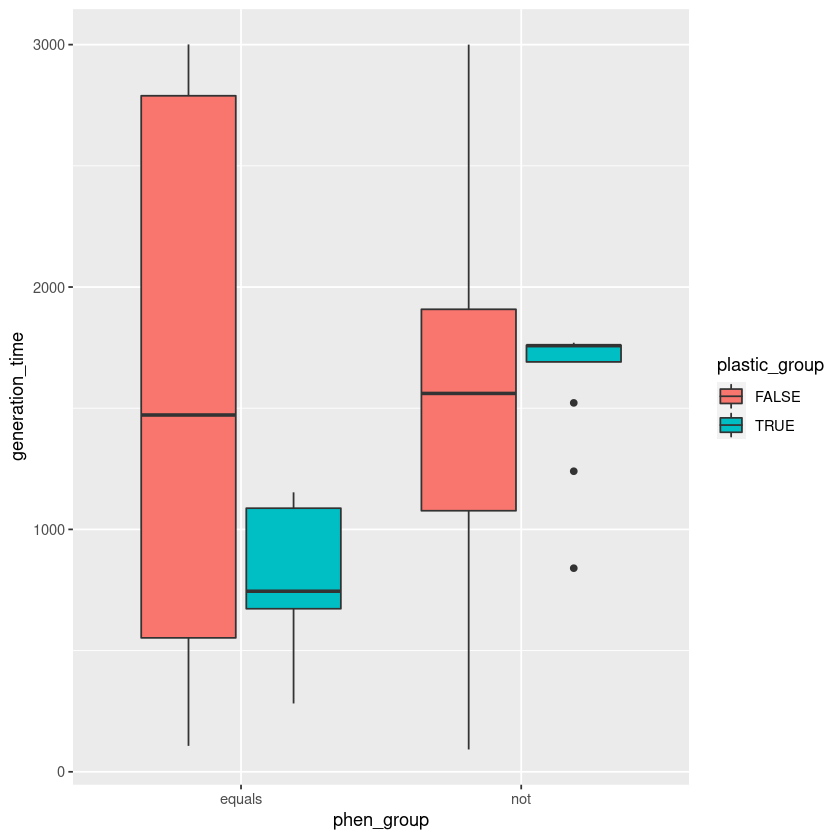

In [6]:
ggplot(df, aes(x = phen_group, y = generation_time, fill = plastic_group)) +
geom_boxplot()

---

## case study: the fitness effects of single-point mutations:

### get the data:

In [7]:
# get data:
data_wild_type <-
    get_genome_id_of_wild_type_organisms(
        triplestore = avidaDB) %>%
    # randomly select the genome of an organism for which all of its single-point mutants are known:
    sample_n(1) %>%
    # get the transcriptome from the genome of the selected organism:
    get_transcriptome_id_from_genome_id(
        genome_id = as.integer(gsub("genome_", "", .$genome_id_wild_type)),
        transcriptome_seq = TRUE,
        seed_id = 1,
        triplestore = avidaDB) %>%
    # get the number of instructions that the organism executed to replicate as a surrogate for fitness:
    mutate(generation_time = nchar(transcriptome_seq)) %>%
    select(genome_id, transcriptome_id, generation_time) %>%
    arrange(generation_time)
# get all single-point mutants from the selected organism:    
data_mutant <-
    # specificy the position of the mutation along the genome of the organism:
    get_mutant_at_pos(
        genome_id = as.integer(
            gsub("genome_", "", data_wild_type$genome_id)),
        triplestore = avidaDB) %>%
    select(genome_id_mutant) %>%
    # get the transcriptome from the genome of the mutant organisms:
    get_transcriptome_id_from_genome_id(
        genome_id = as.integer(gsub("genome_", "", .$genome_id_mutant)),
        transcriptome_seq = TRUE,
        seed_id = 1,
        triplestore = avidaDB) %>%
    select(genome_id, transcriptome_id, transcriptome_seq) %>%
    distinct %>%
    # get the number of instructions that the mutant executed to replicate as a surrogate for fitness:
    mutate(generation_time = nchar(transcriptome_seq)) %>%
    select(-transcriptome_seq) %>%
    # sort the mutants by the number of instructions that the mutant executed to replicate:
    arrange(generation_time) %>%
    # select a single mutant organism, i.e., the one with the highest fitness:
    head(1)

### join them in a single dataframe:

In [8]:
df <- inner_join(
    rbind(data_wild_type, data_mutant),
    get_genome_seq_from_genome_id(
        genome_id = c(as.integer(
            gsub("genome_", "", data_wild_type$genome_id)),
                      as.integer(
            gsub("genome_", "", data_mutant$genome_id))),
        triplestore = avidaDB),
    by = "genome_id")

# get the relative fitness of the mutant compared to that of the wildtype:
df$generation_time[1] / df$generation_time[2]
    
# get the position of the mutation in the genome of the mutant:
pos <- mapply(function(x, y) which(x != y)[1],
    strsplit(df$genome_seq[1], ""), strsplit(df$genome_seq[2], ""))
       
# get the mutated instruction:
substr(df$genome_seq[1], pos, pos)
substr(df$genome_seq[2], pos, pos)

[1] 1.424125

[1] "y"

[1] "z"

### plot and save the transcriptome:

In [ ]:
plot_transcriptome(
    inst_set = "heads",
    transcriptome_id = as.integer(
        gsub("transcriptome_", "", df$transcriptome_id[1])),
    seed_id = 1,
    save = TRUE, save_path = getwd(), format = "pdf",
    triplestore = avidaDB)

---
---